In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, scale
import statsmodels.api as sm

from tempfile import mkdtemp
from shutil import rmtree
import joblib
from joblib import Memory
location = './cachedir2'
memory_ = Memory(location, verbose=1)

In [2]:
# for map data

import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json
import plotly.express as px
import nbformat as nb
from sklearn.metrics import r2_score

with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [213]:
df_main = pd.read_csv(r"Datasets\df_main.csv")
df_main['fips'] = df_main['fips'].astype(str).apply(lambda x: x.zfill(5))
df_main.head()

,fips,Staffed_Beds,Total_Discharges,Patient_Days,Gross_Patient_Revenue,Hospitals,Local_Hospital,ADI_NATRANK,ADI_STATERNK,Value_education,...,pop_sex_female_age_65_and_above,pop_sex_male_age_0_to_18,pop_sex_male_age_18_to_65,pop_sex_male_age_65_and_above,pct_pop_sex_female_age_0_to_18,pct_pop_sex_female_age_18_to_65,pct_pop_sex_female_age_65_and_above,pct_pop_sex_male_age_0_to_18,pct_pop_sex_male_age_18_to_65,pct_pop_sex_male_age_65_and_above
0,01001,77.0,3049.0,15984.0,250284.0,1.0,1,66.977778,4.355556,21.714286,...,4807,6765,16604,3683,11.463182,2.703566e+05,8.639623,12.158738,29.842378,6.619459
1,01003,301.0,18080.0,78361.0,2481966.0,3.0,1,51.534483,2.655172,21.928571,...,24115,23873,61415,20601,10.591464,1.052924e+06,11.047282,10.936420,28.134720,9.437488
2,01005,47.0,1055.0,4571.0,76099.0,1.0,1,90.900000,7.950000,22.285714,...,2704,2589,8494,2073,10.521058,1.189912e+05,10.804763,10.345241,33.940702,8.283385
3,01007,156.0,229.0,1053.0,31288.0,1.0,1,83.411765,6.647059,21.571429,...,2059,2509,7896,1617,9.274157,1.064437e+05,9.202647,11.213908,35.290962,7.227138
4,01009,0.0,0.0,0.0,0.0,0.0,0,72.325581,4.906977,21.571429,...,5747,6873,17169,4635,11.252705,2.780570e+05,9.950653,11.900268,29.727297,8.025280


### Initial Regression Models

In [214]:
train, test = train_test_split(df_main, test_size=0.2, random_state=42)

# train data
X_train = train.drop(columns=['fips', 'avg_death_rate'])
y_train = train['avg_death_rate']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = sm.add_constant(X_train)

# test data
X_test = test.drop(columns=['fips', 'avg_death_rate'])
y_test = test['avg_death_rate']

X_test = scaler.transform(X_test)
X_test = sm.add_constant(X_test)

In [235]:
linear_model = LinearRegression()
ridge_model = Ridge()
lasso_model = Lasso()
elastic_net_model = ElasticNet()
random_forest_model = RandomForestRegressor()

ensemble_clf = [linear_model, ridge_model, lasso_model, elastic_net_model, random_forest_model]
model_names = ["linear regression", "ridge regression", "lasso regression", "elastic net", "random forest"]

# parameters for each model
params1 = {}
params2 = {'alpha':[0.1, 0.01, 0.001, 0.0001]}
params3 = {'alpha':[10000, 1000, 100, 10, 1, 0.1]}
params4 = {'alpha':[10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 'l1_ratio': [0.1, 0.2, 0.5, 0.7, 0.9]}
params5 = {'max_depth':[10,50,80], 'n_estimators':[5,10,50,80,100]}

parameters_list = [params1, params2, params3, params4, params5]

In [216]:
df = pd.DataFrame()


for i in range(len(ensemble_clf)):
        # modeling with 5 fold cross validation
        cv = RepeatedKFold(n_splits=10,  n_repeats=3, random_state=1)
        Grid=GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                        n_jobs=-1, cv=5, verbose=3, scoring = "r2").fit(X_train, y_train)
        data = pd.DataFrame(Grid.cv_results_)

        data = data[['params', 'mean_test_score']] # keep only important columns 
        rows = data.shape[0]
        names = [model_names[i]] * rows
        data['model_name'] = names # create column for model name 

        # modeling on entire training set 
        cv=[(slice(None), slice(None))]
        Grid_all=GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                        n_jobs=-1, cv=cv, verbose=3, scoring = "r2").fit(X_train, y_train)
        data['full_train_score'] = Grid_all.cv_results_['mean_test_score']

        # append entire data frame
        df = df.append(data) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\jacly\anaconda3\envs\interviews\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning:

One or more of the test scores are non-finite: [nan]



Fitting 1 folds for each of 1 candidates, totalling 1 fits


c:\Users\jacly\anaconda3\envs\interviews\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning:

One or more of the test scores are non-finite: [nan]

C:\Users\jacly\AppData\Local\Temp\ipykernel_31692\651301491.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 1 folds for each of 5 candidates, totalling 5 fits


C:\Users\jacly\AppData\Local\Temp\ipykernel_31692\651301491.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 1 folds for each of 7 candidates, totalling 7 fits


c:\Users\jacly\anaconda3\envs\interviews\Lib\site-packages\sklearn\model_selection\_search.py:909: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

c:\Users\jacly\anaconda3\envs\interviews\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

c:\Users\jacly\anaconda3\envs\interviews\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.014e-01, tolerance: 1.217e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

C:\Users\jacly\AppData\Local\Temp\ipykernel_31692\6

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits


c:\Users\jacly\anaconda3\envs\interviews\Lib\site-packages\sklearn\model_selection\_search.py:909: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

c:\Users\jacly\anaconda3\envs\interviews\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

c:\Users\jacly\anaconda3\envs\interviews\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.014e-01, tolerance: 1.217e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

C:\Users\jacly\AppData\Local\Temp\ipykernel_31692\6

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 1 folds for each of 15 candidates, totalling 15 fits


C:\Users\jacly\AppData\Local\Temp\ipykernel_31692\651301491.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [219]:
df_new.groupby('model_name')['mean_test_score'].max()


model_name
elastic net          0.078961
lasso regression    -0.002819
linear regression         NaN
random forest        0.034379
ridge regression    -0.264495
Name: mean_test_score, dtype: float64

In [217]:
df_new = df.reset_index()
df_new.groupby('model_name')['mean_test_score'].idxmax()


model_name
elastic net          54.0
lasso regression      6.0
linear regression     NaN
random forest        66.0
ridge regression      2.0
Name: mean_test_score, dtype: float64

In [220]:
indices_mean_test_score = [54, 6, 66, 2]
df_new.loc[indices_mean_test_score]

,index,params,mean_test_score,model_name,full_train_score
54,41,"{'alpha': 0.001, 'l1_ratio': 0.2}",0.078961,elastic net,0.137149
6,0,{'alpha': 10000},-0.002819,lasso regression,0.000000
66,3,"{'max_depth': 10, 'n_estimators': 80}",0.034379,random forest,0.595128
2,1,{'alpha': 0.1},-0.264495,ridge regression,0.181175


In [236]:
# for linear regression b/c it didn't work before lol
cv = RepeatedKFold(n_splits=10,  n_repeats=3, random_state=1)
Grid=GridSearchCV(estimator=ensemble_clf[0], param_grid=parameters_list[0], 
                n_jobs=-1, cv=5, verbose=3, scoring = "r2").fit(X_train, y_train)
data = pd.DataFrame(Grid.cv_results_)

data = data[['params', 'mean_test_score']] # keep only important columns 
rows = data.shape[0]
names = [model_names[0]] * rows
data['model_name'] = names # create column for model name 

# modeling on entire training set 
cv=[(slice(None), slice(None))]
Grid_all=GridSearchCV(estimator=ensemble_clf[0], param_grid=parameters_list[0], 
                n_jobs=-1, cv=cv, verbose=3, scoring = "r2").fit(X_train, y_train)
data['full_train_score'] = Grid_all.cv_results_['mean_test_score']

# append entire data frame


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits


In [237]:
data

,params,mean_test_score,model_name,full_train_score
0,{},-0.364454,linear regression,0.189749


In [231]:
l = LinearRegression()

In [232]:
l.fit(X_train,y_train)

LinearRegression()

In [233]:
l.score(X_test,y_test)

0.033769024014733584

### Robust Regression to narrow dataset

In [4]:
from sklearn.preprocessing import StandardScaler, scale
import statsmodels.api as sm
# data prep

X = df_main.drop(columns=['fips', 'avg_death_rate'])
X_names = X
y = df_main['avg_death_rate']

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = sm.add_constant(X)

In [5]:
def evaluate_huber(X_new, y_new):
    kf = KFold(n_splits=5)
    r2_train = []
    r2_test = []
    for train_index, test_index in kf.split(X_new):
            X_train, X_test = X_new[train_index], X_new[test_index]
            y_train, y_test = y_new[train_index], y_new[test_index]
            
            # run linear regression 
            reg = LinearRegression()
            reg.fit(X_train, y_train)
            r2_train_score = reg.score(X_train,y_train)
            r2_test_score = reg.score(X_test,y_test)
            r2_test.append(r2_test_score)
            r2_train.append(r2_train_score)
    return(np.mean(r2_train), np.mean(r2_test))

In [6]:
alphas = [0.1, 0.01, 0.001, 0.0001]
epsilon = [1.35, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
results = pd.DataFrame({'Huber_Epsilon': pd.Series(dtype='float'),
                   'Huber_Alpha': pd.Series(dtype='float'),
                   'Huber_R2': pd.Series(dtype='float'),
                   'Data_Percent_Kept': pd.Series(dtype='float'),
                   'Linear_Model_Train_R2': pd.Series(dtype='float'),
                   'Linear_Model_Test_R2': pd.Series(dtype='float')})


for a in alphas:
    for ep in epsilon:
        # run huber model
        print("iteration alpha: {},  epsilon: {}".format(a, ep))
        huber_model = HuberRegressor(max_iter = 10000, epsilon = ep, alpha = a) # change epsilon to change outlier percentage
        huber_model.fit(X,y)
        huber_score = huber_model.score(X,y)

        # Subset data without outliers 
        huber_outliers = huber_model.outliers_
        huber_non_outliers = np.invert(huber_outliers) # invert bools so false is outlier 
        non_outliers = pd.Series(huber_non_outliers)
        per_data = (sum(non_outliers)/len(non_outliers))
        new_df = df_main[non_outliers.values]

        # prepare data for modeling
        new_df.reset_index(drop = True)
        X_new = new_df.drop(columns=['fips', 'avg_death_rate'])
        y_new = new_df['avg_death_rate']
        y_new = y_new.reset_index(drop = True)

        scaler = StandardScaler()
        X_new = scaler.fit_transform(X_new)
        X_new = sm.add_constant(X_new)

        # run linear regression model 
        train_r2, test_r2 = evaluate_huber(X_new,y_new)

        # print results
        print('Alpha: ', a, ', Epsilon: ', ep)
        print('Percentage of data kept after removing outliers: ', per_data)
        print('Huber R2 ', huber_score)
        print('R2 train: ', train_r2)
        print('R2 test: ', test_r2)

        # save results in dataframe 
        results.loc[len(results.index)] = [ep, a, round(huber_score,2), round(per_data, 2), round(train_r2,2), round(test_r2,2)]



iteration alpha: 0.1,  epsilon: 1.35
Alpha:  0.1 , Epsilon:  1.35
Percentage of data kept after removing outliers:  0.6520486555697823
Huber R2  0.10172670707446985
R2 train:  0.7946768493382341
R2 test:  0.38779375711854874
iteration alpha: 0.1,  epsilon: 1.4
Alpha:  0.1 , Epsilon:  1.4
Percentage of data kept after removing outliers:  0.6936619718309859
Huber R2  0.10806933172189848
R2 train:  0.762392616618868
R2 test:  0.33769458949143016
iteration alpha: 0.1,  epsilon: 1.5
Alpha:  0.1 , Epsilon:  1.5
Percentage of data kept after removing outliers:  0.7628040973111395
Huber R2  0.11985365632805822
R2 train:  0.6920960382859846
R2 test:  0.3364210104619333
iteration alpha: 0.1,  epsilon: 1.6
Alpha:  0.1 , Epsilon:  1.6
Percentage of data kept after removing outliers:  0.8133802816901409
Huber R2  0.12972750764094687
R2 train:  0.6134657192496211
R2 test:  0.17252779035767837
iteration alpha: 0.1,  epsilon: 1.7
Alpha:  0.1 , Epsilon:  1.7
Percentage of data kept after removing outli

In [8]:
results.to_csv(r"Datasets\robust_results.csv")

#### Plot parameter results 

In [17]:
alpha_values = results[['Huber_Alpha', 'Huber_Epsilon', 'Linear_Model_Train_R2', 'Linear_Model_Test_R2']]
alpha_values = alpha_values[alpha_values['Huber_Epsilon'] == 1.7]
alpha_values = alpha_values.drop(['Huber_Epsilon'], axis = 1)

In [19]:
alpha_values

,Huber_Alpha,Linear_Model_Train_R2,Linear_Model_Test_R2
4,0.1000,0.57,0.19
12,0.0100,0.57,0.19
20,0.0010,0.57,0.21
28,0.0001,0.57,0.19


Text(0, 0.5, 'R2')

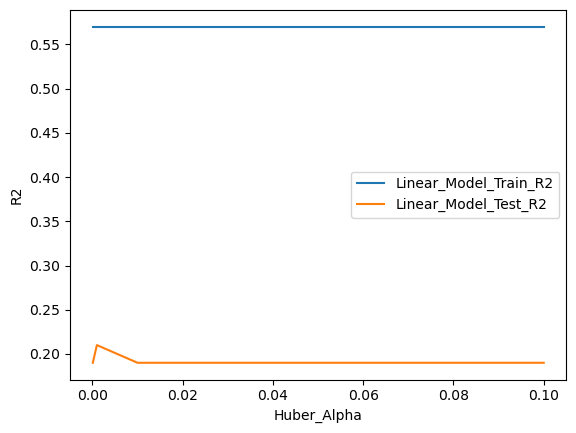

In [24]:
# alpha value of 0.001 works best 
alpha_values.plot(x = 'Huber_Alpha', y = ['Linear_Model_Train_R2', 'Linear_Model_Test_R2'])
plt.ylabel('R2')

In [22]:
epsilon_values = results[['Huber_Alpha', 'Huber_Epsilon', 'Linear_Model_Train_R2', 'Linear_Model_Test_R2']]
epsilon_values = epsilon_values[epsilon_values['Huber_Alpha'] == 0.001]
epsilon_values = epsilon_values.drop(['Huber_Alpha'], axis = 1)

Text(0, 0.5, 'R2')

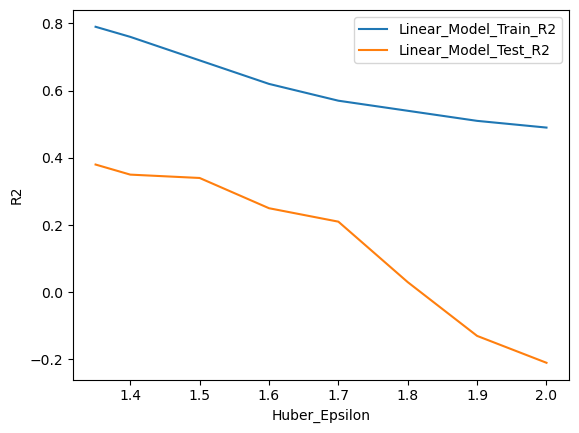

In [25]:
epsilon_values.plot(x = 'Huber_Epsilon', y = ['Linear_Model_Train_R2', 'Linear_Model_Test_R2'])
plt.ylabel('R2')

In [29]:
epsilon_values = results[results['Huber_Alpha'] == 0.001]
epsilon_values = epsilon_values.drop(['Huber_Alpha'], axis = 1)

Text(0, 0.5, 'R2')

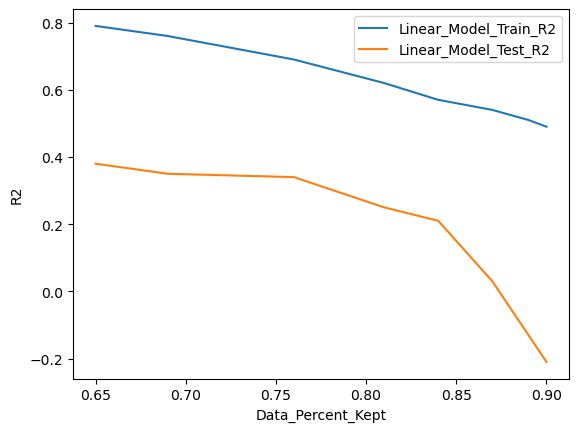

In [31]:
epsilon_values.plot(x = 'Data_Percent_Kept', y = ['Linear_Model_Train_R2', 'Linear_Model_Test_R2'])
plt.ylabel('R2')

optimal values are alpha = 0.001 and epsilon = 1.5 and 1. 7

In [33]:
# save dataset for alpha = 0.001, epsilon = 1.5
huber_model_15 = HuberRegressor(max_iter = 10000, epsilon = 1.5, alpha = 0.001) # change epsilon to change outlier percentage
huber_model_15.fit(X,y)

huber_outliers_15 = huber_model_15.outliers_
huber_non_outliers_15 = np.invert(huber_outliers_15) # invert bools so false is outlier 
non_outliers_15 = pd.Series(huber_non_outliers_15)
outliers_15 = pd.Series(huber_outliers_15)
new_df_15 = df_main[non_outliers_15.values]
df_outliers_15 = df_main[outliers_15.values]

# percentage of data kept after removing outliers

print('Percentage of data kept after removing outliers: %.3f' % (sum(non_outliers_15)/len(non_outliers_15)))

Percentage of data kept after removing outliers: 0.763


In [ ]:
# map of outliers 

fig = px.choropleth(df_outliers_15,
                    locations = 'fips',
                    geojson = counties,
                    scope = "usa")
fig.update_layout(
      title_text = 'Fips counties considered as Outliers (~25%)',
      title_font_family="Times New Roman",
      title_font_size = 22,
      title_font_color="black",
      title_x=0.45,
         )
fig.show()

In [34]:
huber_model_17 = HuberRegressor(max_iter = 10000, epsilon = 1.7, alpha = 0.001) # change epsilon to change outlier percentage
huber_model_17.fit(X,y)

huber_outliers_17 = huber_model_17.outliers_
huber_non_outliers_17 = np.invert(huber_outliers_17) # invert bools so false is outlier 
non_outliers_17 = pd.Series(huber_non_outliers_17)
outliers_17 = pd.Series(huber_outliers_17)
new_df_17 = df_main[non_outliers_17.values]
df_outliers_17 = df_main[outliers_17.values]

# percentage of data kept after removing outliers

print('Percentage of data kept after removing outliers: %.3f' % (sum(non_outliers_17)/len(non_outliers_17)))

Percentage of data kept after removing outliers: 0.844


In [ ]:
# map of outliers 

fig = px.choropleth(df_outliers_17,
                    locations = 'fips',
                    geojson = counties,
                    scope = "usa")
fig.update_layout(
      title_text = 'Fips counties considered as Outliers (~15%)',
      title_font_family="Times New Roman",
      title_font_size = 22,
      title_font_color="black",
      title_x=0.45,
         )
fig.show()

### save data files

In [35]:
new_df_15.to_csv(r"Datasets\df_15.csv")
new_df_17.to_csv(r"Datasets\df_17.csv")

In [49]:
df_outliers_15.to_csv(r"Datasets\df_outliers_15.csv")
df_outliers_17.to_csv(r"Datasets\df_outliers_17.csv")

# Regression Models 

### import dataset epsilon = 1.5

In [6]:
df_main = pd.read_csv(r"Datasets\df_15.csv", index_col = False)
df_main['fips'] = df_main['fips'].astype(str).apply(lambda x: x.zfill(5))
df_main.shape

(2383, 276)

In [245]:
df_main.columns

Index(['Unnamed: 0', 'fips', 'Staffed_Beds', 'Total_Discharges',
       'Patient_Days', 'Gross_Patient_Revenue', 'Hospitals', 'Local_Hospital',
       'ADI_NATRANK', 'ADI_STATERNK',
       ...
       'pop_sex_female_age_65_and_above', 'pop_sex_male_age_0_to_18',
       'pop_sex_male_age_18_to_65', 'pop_sex_male_age_65_and_above',
       'pct_pop_sex_female_age_0_to_18', 'pct_pop_sex_female_age_18_to_65',
       'pct_pop_sex_female_age_65_and_above', 'pct_pop_sex_male_age_0_to_18',
       'pct_pop_sex_male_age_18_to_65', 'pct_pop_sex_male_age_65_and_above'],
      dtype='object', length=276)

In [7]:
# Split dataset 0.8/0.2
train, test = train_test_split(df_main, test_size=0.2, random_state=42)

# train data
X_train = train.drop(columns=['fips', 'avg_death_rate', 'Unnamed: 0'])
y_train = train['avg_death_rate']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = sm.add_constant(X_train)

# test data
X_test = test.drop(columns=['fips', 'avg_death_rate', 'Unnamed: 0'])
y_test = test['avg_death_rate']

X_test = scaler.transform(X_test)
X_test = sm.add_constant(X_test)

### run regression models

In [26]:
linear_model = LinearRegression()
ridge_model = Ridge()
lasso_model = Lasso()
elastic_net_model = ElasticNet()
random_forest_model = RandomForestRegressor()

ensemble_clf = [linear_model, ridge_model, lasso_model, elastic_net_model, random_forest_model]
model_names = ["linear regression", "ridge regression", "lasso regression", "elastic net", "random forest"]

# parameters for each model
params1 = {}
params2 = {'alpha':[10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]}
params3 = {'alpha':[10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]}
params4 = {'alpha':[10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 'l1_ratio': [0.1, 0.2, 0.5, 0.7, 0.9]}
params5 = {'max_depth':[10,50,80], 'n_estimators':[5,10,50,80,100]}

parameters_list = [params1, params2, params3, params4, params5]


In [27]:
df = pd.DataFrame()


for i in range(len(ensemble_clf)):
        # modeling with 5 fold cross validation
        cv = RepeatedKFold(n_splits=10,  n_repeats=3, random_state=1)
        Grid=GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                        n_jobs=-1, cv=5, verbose=3, scoring = "r2").fit(X_train, y_train)
        data = pd.DataFrame(Grid.cv_results_)

        data = data[['params', 'mean_test_score']] # keep only important columns 
        rows = data.shape[0]
        names = [model_names[i]] * rows
        data['model_name'] = names # create column for model name 

        # modeling on entire training set 
        cv=[(slice(None), slice(None))]
        Grid_all=GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                        n_jobs=-1, cv=cv, verbose=3, scoring = "r2").fit(X_train, y_train)
        data['full_train_score'] = Grid_all.cv_results_['mean_test_score']

        # append entire data frame
        df = df.append(data) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits


C:\Users\jacly\AppData\Local\Temp\ipykernel_18848\651301491.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 1 folds for each of 9 candidates, totalling 9 fits


C:\Users\jacly\AppData\Local\Temp\ipykernel_18848\651301491.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 1 folds for each of 9 candidates, totalling 9 fits


C:\Users\jacly\AppData\Local\Temp\ipykernel_18848\651301491.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Fitting 1 folds for each of 45 candidates, totalling 45 fits


c:\Users\jacly\anaconda3\envs\interviews\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.308e-02, tolerance: 2.447e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacly\AppData\Local\Temp\ipykernel_18848\651301491.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 1 folds for each of 15 candidates, totalling 15 fits


C:\Users\jacly\AppData\Local\Temp\ipykernel_18848\651301491.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


In [28]:
df.to_csv(r"Datasets\regression_results_15.csv")

In [29]:
df.sort_values(by=['mean_test_score'], ascending = False)

,params,mean_test_score,model_name,full_train_score
43,"{'alpha': 0.0001, 'l1_ratio': 0.7}",0.562094,elastic net,0.623161
44,"{'alpha': 0.0001, 'l1_ratio': 0.9}",0.561724,elastic net,0.615977
42,"{'alpha': 0.0001, 'l1_ratio': 0.5}",0.560588,elastic net,0.632660
8,{'alpha': 0.0001},0.560429,lasso regression,0.612378
35,"{'alpha': 0.001, 'l1_ratio': 0.1}",0.560266,elastic net,0.612113
...,...,...,...,...
33,"{'alpha': 0.01, 'l1_ratio': 0.7}",-0.002515,elastic net,0.000000
34,"{'alpha': 0.01, 'l1_ratio': 0.9}",-0.002515,elastic net,0.000000
12,"{'alpha': 100, 'l1_ratio': 0.5}",-0.002515,elastic net,0.000000
14,"{'alpha': 100, 'l1_ratio': 0.9}",-0.002515,elastic net,0.000000


In [30]:
df_new = df.reset_index()

In [31]:
df_new.groupby('model_name')['mean_test_score'].idxmax()

model_name
elastic net          62
lasso regression     18
linear regression     0
random forest        78
ridge regression      3
Name: mean_test_score, dtype: int64

In [32]:
df_new.groupby('model_name')['mean_test_score'].max()

model_name
elastic net          0.562094
lasso regression     0.560429
linear regression    0.426907
random forest        0.524116
ridge regression     0.556450
Name: mean_test_score, dtype: float64

In [33]:
indices_mean_test_score = [62, 18, 0, 78,3]

In [34]:
df_new.loc[indices_mean_test_score]

,index,params,mean_test_score,model_name,full_train_score
62,43,"{'alpha': 0.0001, 'l1_ratio': 0.7}",0.562094,elastic net,0.623161
18,8,{'alpha': 0.0001},0.560429,lasso regression,0.612378
0,0,{},0.426907,linear regression,0.692965
78,14,"{'max_depth': 80, 'n_estimators': 100}",0.524116,random forest,0.933980
3,2,{'alpha': 100},0.556450,ridge regression,0.638736


In [35]:
df_new[df_new['model_name'] == 'random forest']

,index,params,mean_test_score,model_name,full_train_score
64,0,"{'max_depth': 10, 'n_estimators': 5}",0.431512,random forest,0.834844
65,1,"{'max_depth': 10, 'n_estimators': 10}",0.478648,random forest,0.862325
66,2,"{'max_depth': 10, 'n_estimators': 50}",0.517109,random forest,0.879049
67,3,"{'max_depth': 10, 'n_estimators': 80}",0.520782,random forest,0.879886
68,4,"{'max_depth': 10, 'n_estimators': 100}",0.518221,random forest,0.879536
69,5,"{'max_depth': 50, 'n_estimators': 5}",0.396862,random forest,0.876419
70,6,"{'max_depth': 50, 'n_estimators': 10}",0.483380,random forest,0.899242
71,7,"{'max_depth': 50, 'n_estimators': 50}",0.517569,random forest,0.933259
72,8,"{'max_depth': 50, 'n_estimators': 80}",0.520712,random forest,0.932983
73,9,"{'max_depth': 50, 'n_estimators': 100}",0.521134,random forest,0.934279


### Best parameters for each model 

train each model on the 80% of the data and test on 20% of data

In [36]:
# models 
linear_model = LinearRegression()
ridge_model = Ridge(alpha = 100)
lasso_model = Lasso(alpha = 0.0001)
elastic_net_model = ElasticNet(alpha = 0.001, l1_ratio = 0.7)
random_forest_model = RandomForestRegressor(max_depth = 80, n_estimators = 100)

# train models 
linear_model.fit(X_train,y_train)
ridge_model.fit(X_train,y_train)
lasso_model.fit(X_train,y_train)
elastic_net_model.fit(X_train,y_train)
random_forest_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=80)

In [38]:
print(linear_model.score(X_test, y_test))
print(ridge_model.score(X_test, y_test))
print(lasso_model.score(X_test, y_test))
print(elastic_net_model.score(X_test, y_test))
print(random_forest_model.score(X_test, y_test))

0.223840075128364
0.5758970380161469
0.4736453760063788
0.3635005381150609
0.5559378378850285


In [39]:
# light gbm best model from jason's script
lgb_reg_original = lgb.LGBMRegressor(
  boosting_type = 'dart',
  num_leaves = 180,
  max_depth = 46,
  learning_rate = 0.31716787155468795,
  num_iterations = 247,
  min_data_in_leaf = 28,
  verbose = 1
)

lgb_reg_original.fit(X_train, y_train)

c:\Users\jacly\anaconda3\envs\interviews\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67544
[LightGBM] [Info] Number of data points in the train set: 1906, number of used features: 273
[LightGBM] [Info] Start training from score 0.012632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

LGBMRegressor(boosting_type='dart', learning_rate=0.31716787155468795,
              max_depth=46, min_data_in_leaf=28, num_iterations=247,
              num_leaves=180, verbose=1)

In [40]:
lgb_reg_original.score(X_test, y_test)

0.5652196514856133

In [96]:
# # get predicted y values on 20% of data 
# linear_y_predicted = linear_model.predict(X_test)
# ridge_y_predicted = ridge_model.predict(X_test)
# lasso_y_predicted = lasso_model.predict(X_test)
# elastic_y_predicted = elastic_net_model.predict(X_test)
# random_y_predicted = random_forest_model.predict(X_test)
# # get r2 values 
# print(r2_score(linear_y_predicted, y_test))
# print(r2_score(ridge_y_predicted, y_test))
# print(r2_score(lasso_y_predicted, y_test))
# print(r2_score(elastic_y_predicted, y_test))
# print(r2_score(random_y_predicted, y_test))


0.3041197065812502
0.3072642177838897
0.32966361370599817
0.28433095991063595
0.15577151619729224


### train on full dataset with optimized hyperparameters

In [41]:
X = df_main.drop(columns=['fips', 'avg_death_rate', 'Unnamed: 0'])
y = df_main['avg_death_rate']

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = sm.add_constant(X)

In [42]:
# models 
linear_model = LinearRegression()
ridge_model = Ridge(alpha = 100)
lasso_model = Lasso(alpha = 0.0001)
elastic_net_model = ElasticNet(alpha = 0.001, l1_ratio = 0.7)
random_forest_model = RandomForestRegressor(max_depth = 80, n_estimators = 100)
lgb_reg_original = lgb.LGBMRegressor(
  boosting_type = 'dart',
  num_leaves = 180,
  max_depth = 46,
  learning_rate = 0.31716787155468795,
  num_iterations = 247,
  min_data_in_leaf = 28,
  verbose = 1
)

# train models 
linear_model.fit(X,y)
ridge_model.fit(X,y)
lasso_model.fit(X,y)
elastic_net_model.fit(X,y)
random_forest_model.fit(X,y)
lgb_reg_original.fit(X, y)

c:\Users\jacly\anaconda3\envs\interviews\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67971
[LightGBM] [Info] Number of data points in the train set: 2383, number of used features: 273
[LightGBM] [Info] Start training from score 0.012705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

LGBMRegressor(boosting_type='dart', learning_rate=0.31716787155468795,
              max_depth=46, min_data_in_leaf=28, num_iterations=247,
              num_leaves=180, verbose=1)

In [43]:
# r2 score
linear_model_score = linear_model.score(X,y)
ridge_model_score = ridge_model.score(X,y)
lasso_model_score = lasso_model.score(X,y)
elastic_net_score = elastic_net_model.score(X,y)
random_forest_core = random_forest_model.score(X,y)
lgb_reg_score = lgb_reg_original.score(X,y)

In [44]:
print(linear_model_score)
print(ridge_model_score)
print(lasso_model_score)
print(elastic_net_score)
print(random_forest_core)
print(lgb_reg_score)

0.6838425865761635
0.6346593995411995
0.6050306028966597
0.4434953234740632
0.9360466143643479
0.9967863320622296


# Feature Selection 


In [90]:
from sklearn.inspection import permutation_importance

In [91]:
df_main = pd.read_csv(r"Datasets\df_15.csv", index_col = False)
df_main['fips'] = df_main['fips'].astype(str).apply(lambda x: x.zfill(5))
df_main.shape

(2383, 276)

### linear regression with ABESS

In [92]:
X = df_main.drop(columns=['fips', 'avg_death_rate', 'Unnamed: 0'])
X_names = X
column_names = X_names.columns
y = df_main['avg_death_rate']

scaler = StandardScaler()
X = scaler.fit_transform(X)

column_names = X_names.columns
X = pd.DataFrame(X)
X.columns = column_names


In [93]:
from abess.linear import LinearRegression

support_size_range = 20
model = LinearRegression(support_size = range(support_size_range))
model.fit(X, y)

LinearRegression(support_size=range(0, 20))

In [94]:
model.score(X,y)

0.4561431873491669

In [96]:
col_num = X.shape[1] # get dimension of data
ind = np.nonzero(model.coef_)
print("non-zero:\n", X_names.columns[ind])
print("coef:\n", model.coef_[ind])

non-zero:
 Index(['Local_Hospital', 'pct_pop_commute_travel_time_5_to_9_min',
       'pct_pop_commute_travel_time_under_5_min',
       'pop_commute_travel_time_under_5_min',
       'pop_works_in_state_different_county_of_residence',
       'pct_pop_race_black', 'pct_pop_race_white',
       'pop_ethnicity_non_hispanic', 'households_with_computing_devices_none',
       'households_with_no_internet_access', 'pct_households_female_head',
       'pop_sex_female_age_65_and_above'],
      dtype='object')
coef:
 [ 0.00197096 -0.00113713 -0.00110605  0.00282857  0.00308934  0.00243476
 -0.00025107 -0.00611128  0.02054885 -0.0205037   0.00091065  0.00370858]


In [98]:
names = X_names.columns[ind]
coefficients = model.coef_[ind]

In [101]:
abess_results = pd.DataFrame({
  "names": names,
  "coefficients": coefficients
})

In [102]:
abess_results['absolute_coefficients'] = abs(abess_results['coefficients'])

In [105]:
abess_results.sort_values(by = 'absolute_coefficients', ascending = False)

,names,coefficients,absolute_coefficients
8,households_with_computing_devices_none,0.020549,0.020549
9,households_with_no_internet_access,-0.020504,0.020504
7,pop_ethnicity_non_hispanic,-0.006111,0.006111
11,pop_sex_female_age_65_and_above,0.003709,0.003709
4,pop_works_in_state_different_county_of_residence,0.003089,0.003089
3,pop_commute_travel_time_under_5_min,0.002829,0.002829
5,pct_pop_race_black,0.002435,0.002435
0,Local_Hospital,0.001971,0.001971
1,pct_pop_commute_travel_time_5_to_9_min,-0.001137,0.001137
2,pct_pop_commute_travel_time_under_5_min,-0.001106,0.001106


In [107]:
sorted_list = abess_results.sort_values(by = 'absolute_coefficients', ascending = False)['names']

In [110]:
list(sorted_list)

['households_with_computing_devices_none',
 'households_with_no_internet_access',
 'pop_ethnicity_non_hispanic',
 'pop_sex_female_age_65_and_above',
 'pop_works_in_state_different_county_of_residence',
 'pop_commute_travel_time_under_5_min',
 'pct_pop_race_black',
 'Local_Hospital',
 'pct_pop_commute_travel_time_5_to_9_min',
 'pct_pop_commute_travel_time_under_5_min',
 'pct_households_female_head',
 'pct_pop_race_white']

In [ ]:
print("non-zero:\n", X_names.columns[ind])
print("coef:\n", model.coef_)

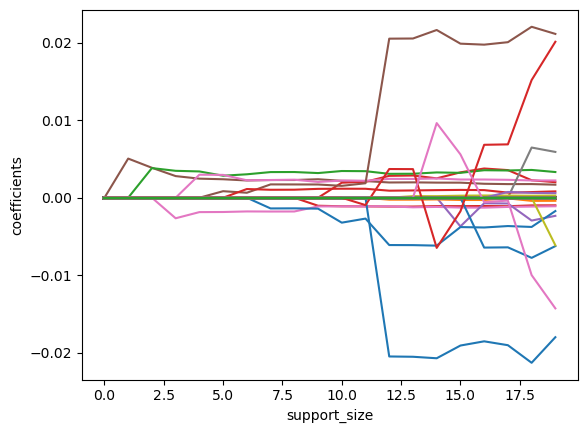

In [49]:
coef = np.zeros((support_size_range, col_num))
ic = np.zeros(support_size_range)
for s in range(support_size_range):
    model = LinearRegression(support_size=s)
    model.fit(X, y)
    coef[s, :] = model.coef_
    ic[s] = model.eval_loss_

for i in range(col_num):
    plt.plot(coef[:, i], label=i)

plt.xlabel('support_size')
plt.ylabel('coefficients')
# plt.title('ABESS Path')
plt.show()

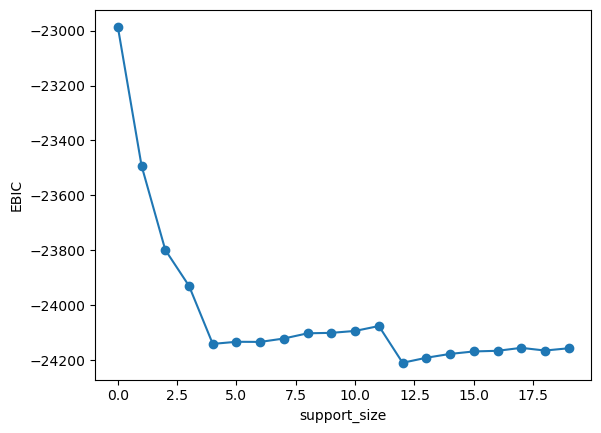

In [50]:
plt.plot(ic, 'o-')
plt.xlabel('support_size')
plt.ylabel('EBIC')
# plt.title('Model selection via EBIC')
plt.show()

In [82]:
from sklearn.linear_model import LinearRegression

In [83]:
linear_model = LinearRegression()
linear_model.fit(X,y)
r = permutation_importance(linear_model, X, y, random_state = 42)
importances = r.importances_mean

In [84]:
feature_list = list(X_names.columns)

feature_importances = [(feature, round(imp, 2)) for feature, imp in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
top_20 = feature_importances[0:20]
top_20

[('pct_pop_race_white', 684081659101.69),
 ('pct_pop_race_black', 461519328533.83),
 ('pct_pop_ethnicity_hispanic_latino', 437924219547.37),
 ('pct_pop_ethnicity_non_hispanic', 437923898395.06),
 ('pct_pop_birthplace_us', 188034627977.47),
 ('pct_pop_commutes_by_car_truck_van_any', 180825716555.25),
 ('pct_pop_commutes_by_car_truck_van_alone', 170540234864.62),
 ('pct_households_with_computing_devices_total', 155448162509.38),
 ('pct_households_with_computing_devices_none', 155448145780.61),
 ('pct_pop_race_native_american', 148827069590.76),
 ('pct_households_married_couple', 101502809279.57),
 ('pct_pop_works_in_county_of_residence', 90130300736.8),
 ('pct_pop_works_in_state_different_county_of_residence', 63067895635.35),
 ('pct_pop_citizenship_non_us', 59982705878.91),
 ('pct_households_female_head', 57395474677.73),
 ('pct_pop_works_in_state_of_residence', 40910752845.95),
 ('pct_pop_race_other', 39677862322.37),
 ('pct_pop_citizenship_us_naturalized', 38964871936.31),
 ('pct_hous

### Feature Selection for Lasso Regression

In [78]:
lasso_model = Lasso(alpha = 0.0001)
lasso_model.fit(X,y)
r = permutation_importance(lasso_model, X, y, random_state = 42)
importances = r.importances_mean

In [79]:
feature_list = list(X_names.columns)

feature_importances = [(feature, round(imp, 2)) for feature, imp in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
top_20 = feature_importances[0:20]
top_20

[('households_with_computing_devices_none', 0.44),
 ('pop_race_black', 0.2),
 ('pct_pop_race_black', 0.14),
 ('pop_works_in_state_different_county_of_residence', 0.08),
 ('pop_sex_male_age_65_and_above', 0.07),
 ('Local_Hospital', 0.06),
 ('pop_works_from_home', 0.05),
 ('Hospitals', 0.03),
 ('pop_commute_travel_time_under_5_min', 0.03),
 ('pct_pop_ethnicity_hispanic_latino', 0.03),
 ('pop_ethnicity_hispanic_latino', 0.03),
 ('pop_race_other', 0.03),
 ('pct_households_with_annual_income_150000_to_199999', 0.03),
 ('ADI_NATRANK', 0.02),
 ('pop_works_outside_state_of_residence', 0.02),
 ('pop_works_industry_manufacturing', 0.02),
 ('households_with_computing_devices_other_computer', 0.02),
 ('pct_pop_sex_female_age_65_and_above', 0.02),
 ('Value_education', 0.01),
 ('pct_pop_commute_departure_0000_to_0459', 0.01)]

### Feature Selection for Ridge Regression

In [72]:
from sklearn.inspection import permutation_importance

In [73]:
ridge_model = Ridge(alpha = 100)
ridge_model.fit(X,y)
r = permutation_importance(ridge_model, X, y, random_state = 42)
importances = r.importances_mean

Ridge(alpha=100)

In [75]:
feature_list = list(X_names.columns)

feature_importances = [(feature, round(imp, 2)) for feature, imp in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
top_20 = feature_importances[0:20]
top_20

[('pop_race_black', 0.11),
 ('pop_works_from_home', 0.08),
 ('pct_pop_race_black', 0.07),
 ('Local_Hospital', 0.05),
 ('ADI_NATRANK', 0.05),
 ('pop_works_in_state_different_county_of_residence', 0.05),
 ('households_with_computing_devices_none', 0.05),
 ('Hospitals', 0.04),
 ('pop_commute_travel_time_under_5_min', 0.03),
 ('pct_pop_race_white', 0.03),
 ('pop_works_industry_manufacturing', 0.03),
 ('households_with_computing_devices_other_computer', 0.03),
 ('households_with_no_internet_access', 0.03),
 ('pct_pop_commute_departure_0000_to_0459', 0.02),
 ('pop_commute_departure_0000_to_0459', 0.02),
 ('pop_commutes_by_public_transport_ferry', 0.02),
 ('pop_works_outside_state_of_residence', 0.02),
 ('pop_race_native_american', 0.02),
 ('pop_race_other', 0.02),
 ('pop_race_white', 0.02)]

### Feature Selection for Elastic Net 

In [76]:
elastic_net_model = ElasticNet(alpha = 0.0001, l1_ratio = 0.7, max_iter = 10000)
elastic_net_model.fit(X,y)
r = permutation_importance(elastic_net_model, X, y, random_state = 42)
importances = r.importances_mean

In [77]:
feature_list = list(X_names.columns)

feature_importances = [(feature, round(imp, 2)) for feature, imp in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
top_20 = feature_importances[0:20]
top_20

[('households_with_computing_devices_none', 0.46),
 ('pop_race_black', 0.22),
 ('pct_pop_race_black', 0.16),
 ('pop_works_from_home', 0.08),
 ('pop_works_in_state_different_county_of_residence', 0.08),
 ('Local_Hospital', 0.06),
 ('pop_sex_male_age_65_and_above', 0.06),
 ('Hospitals', 0.05),
 ('pop_commute_travel_time_under_5_min', 0.05),
 ('ADI_NATRANK', 0.04),
 ('pct_pop_ethnicity_hispanic_latino', 0.03),
 ('pop_ethnicity_hispanic_latino', 0.03),
 ('pop_race_other', 0.03),
 ('pct_households_with_annual_income_150000_to_199999', 0.03),
 ('households_with_computing_devices_other_computer', 0.03),
 ('pop_commutes_by_public_transport_ferry', 0.02),
 ('pop_works_outside_state_of_residence', 0.02),
 ('pop_race_native_american', 0.02),
 ('pop_works_industry_manufacturing', 0.02),
 ('pop_sex_female_age_65_and_above', 0.02)]

### Feature Selection for Random Forest

In [51]:
random_forest_model = RandomForestRegressor(max_depth = 10, n_estimators = 100)
random_forest_model.fit(X,y)



RandomForestRegressor(max_depth=10)

In [52]:
importances = list(random_forest_model.feature_importances_)

feature_list = list(X_names.columns)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
top_20 = feature_importances[0:20]
top_20


[('pop_race_black', 0.34),
 ('pop_adult_education_less_than_high_school', 0.04),
 ('pop_commutes_by_public_transport_ferry', 0.03),
 ('households_with_computing_devices_none', 0.03),
 ('pct_pop_commutes_by_car_truck_van_carpool', 0.01),
 ('pct_pop_commutes_by_public_transport_subway', 0.01),
 ('pct_pop_has_0_vehicles_available', 0.01),
 ('pct_pop_has_3_or_more_vehicles_available', 0.01),
 ('pct_pop_works_from_home', 0.01),
 ('pop_commute_travel_time_60_to_89_min', 0.01),
 ('pop_commute_travel_time_90_min_or_more', 0.01),
 ('pop_commutes_by_public_transport_lightrail', 0.01),
 ('median_age', 0.01),
 ('median_age_female', 0.01),
 ('pct_pop_citizenship_us_native', 0.01),
 ('pct_pop_ethnicity_non_hispanic', 0.01),
 ('pct_pop_race_black', 0.01),
 ('pct_pop_race_native_american', 0.01),
 ('pop_race_native_american', 0.01),
 ('pct_households_with_annual_income_60000_to_75499', 0.01)]

In [67]:
importances

[0.00111902627647234,
 0.00040770942252289967,
 0.0004416136891029894,
 0.0009785314441443204,
 0.00024094209540723003,
 5.52397414697472e-06,
 0.0026493932135020393,
 0.001547359164884497,
 0.0018807122254516462,
 0.0018543005353323537,
 0.0041084588359566855,
 0.0028501259564229233,
 0.002461774064019332,
 0.0015499985455008477,
 0.002363184472567821,
 0.0035829236513950607,
 0.002926411117588375,
 0.0022873332810556344,
 0.0026633158403305407,
 0.002579006389162886,
 0.002028164705325162,
 0.0019993295894316994,
 0.002599219944784122,
 0.004646089392806728,
 0.0019662606745789245,
 0.0021463939816471368,
 0.0021076853481713557,
 0.0018151327065656997,
 0.0024512480108765497,
 0.00254840530071407,
 0.001921980262067975,
 0.001815739562663458,
 0.0014624140313562698,
 0.004286455822954245,
 0.002538797926325581,
 0.004973508654247883,
 0.002413266611404762,
 0.0007770650440794215,
 0.0017973033279552212,
 0.0016134088925010865,
 0.00819068263502498,
 0.002488299857668102,
 0.001371830

In [59]:
### Feature Selection for Light GBM
lgb_reg_original = lgb.LGBMRegressor(
  boosting_type = 'dart',
  num_leaves = 180,
  max_depth = 46,
  learning_rate = 0.31716787155468795,
  num_iterations = 247,
  min_data_in_leaf = 28,
  verbose = 1
)
lgb_reg_original.fit(X,y)

important_features = lgb_reg_original.feature_importances_

c:\Users\jacly\anaconda3\envs\interviews\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67971
[LightGBM] [Info] Number of data points in the train set: 2383, number of used features: 273
[LightGBM] [Info] Start training from score 0.012705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

In [60]:
feature_ranks = pd.DataFrame({"rank": important_features})
sorted_feature_ranks = feature_ranks.sort_values(by='rank', ascending=False)
sorted_feature_ranks.head(20)

,rank
132,288
119,197
52,179
111,157
271,155
157,153
23,152
113,150
249,145
11,138


In [61]:
top20_index = sorted_feature_ranks.head(20).index
X_names.columns[top20_index]

Index(['pop_race_black', 'pct_pop_race_native_american',
       'pct_pop_has_3_or_more_vehicles_available',
       'pct_pop_citizenship_us_native', 'pct_pop_sex_male_age_18_to_65',
       'pct_households_with_annual_income_60000_to_75499',
       'pct_pop_commute_departure_1200_to_1559',
       'pct_pop_ethnicity_hispanic_latino',
       'pct_pop_adult_education_some_college_or_associates',
       'pct_pop_commute_departure_0000_to_0459',
       'pct_households_married_couple_with_children',
       'pct_households_with_annual_income_30000_to_39999',
       'pct_pop_works_industry_retail_trade', 'ADI_NATRANK',
       'pct_pop_commute_travel_time_20_to_24_min',
       'pct_pop_works_occupation_construction_maintenance',
       'pct_pop_sex_female', 'pct_pop_works_industry_information',
       'pct_pop_commute_departure_0830_to_0859',
       'pct_households_with_computing_devices_smartphone'],
      dtype='object')

In [89]:
pd.DataFrame({
  "feature": X_names.columns[1:][top20_index],
  "Rank": sorted_feature_ranks.head(20)['rank'].to_list()
})

,feature,Rank
0,pop_race_hawaiian_pacific_islander,288
1,pct_pop_race_other,197
2,pct_pop_works_from_home,179
3,pct_pop_citizenship_us_naturalized,157
4,pct_pop_sex_male_age_65_and_above,155
5,pct_households_with_annual_income_75000_to_99999,153
6,pct_pop_commute_departure_1600_to_2359,152
7,pct_pop_ethnicity_non_hispanic,150
8,pct_pop_veterans,145
9,pct_pop_commute_departure_0500_to_0529,138


In [120]:
# print list of all column names
names = list(X_names.columns)

In [121]:
names

['Staffed_Beds',
 'Total_Discharges',
 'Patient_Days',
 'Gross_Patient_Revenue',
 'Hospitals',
 'Local_Hospital',
 'ADI_NATRANK',
 'ADI_STATERNK',
 'Value_education',
 'Value_poverty',
 'Value_unemployment',
 'pct_pop_commute_departure_0000_to_0459',
 'pct_pop_commute_departure_0500_to_0529',
 'pct_pop_commute_departure_0530_to_0559',
 'pct_pop_commute_departure_0600_to_0629',
 'pct_pop_commute_departure_0630_to_0659',
 'pct_pop_commute_departure_0700_to_0729',
 'pct_pop_commute_departure_0730_to_0759',
 'pct_pop_commute_departure_0800_to_0829',
 'pct_pop_commute_departure_0830_to_0859',
 'pct_pop_commute_departure_0900_to_0959',
 'pct_pop_commute_departure_1000_to_1059',
 'pct_pop_commute_departure_1100_to_1159',
 'pct_pop_commute_departure_1200_to_1559',
 'pct_pop_commute_departure_1600_to_2359',
 'pct_pop_commute_travel_time_10_to_14_min',
 'pct_pop_commute_travel_time_15_to_19_min',
 'pct_pop_commute_travel_time_20_to_24_min',
 'pct_pop_commute_travel_time_25_to_29_min',
 'pct_pop_

In [122]:
with open("feature_names.txt", "w") as output:
    output.write(str(names))